In [337]:
import numpy as np
import matplotlib.pyplot as plt
from Functions import *
from collections import namedtuple
from scipy.interpolate import CubicSpline

In [338]:
def Plot_curve(data_arr,Y_legends,
                X_label,Y_label,
                xticks,xtickslabel,
                title,marker_list,
                linestyle_list,
                colors_list,ylim=-1,
                bbox_to_anchor=(),dpi=300):
    #Plot parameters
    figsize = (10,6)
    fonttype = "Helvetica"
    fontsize = 12
    grid_linewidth = 0.8
    plot_linewidth = 1.5
    # colors_list = ['tab:blue']*3+['tab:red']*3+['tab:orange']+['tab:green']
    savename = "results/"+str(title)+".jpg"
    idx = 0
    plt.figure(figsize=figsize)
    for data_idx in range(len(data_arr)):
        X       = data_arr[data_idx][:,0]           #X is a 2D array
        Y_arr   = data_arr[data_idx][:,1:]          #Y_arr is a 2D array
        for Y_idx in range(np.shape(Y_arr)[1]):
            if Y_legends[idx] == "":
                plt.plot(X,Y_arr[:,Y_idx],
                        color=colors_list[idx], marker=marker_list[idx],
                        linestyle=linestyle_list[idx], linewidth=plot_linewidth)
            else:
                plt.plot(X,Y_arr[:,Y_idx],label=Y_legends[idx],
                            color=colors_list[idx], marker=marker_list[idx],
                            linestyle=linestyle_list[idx], linewidth=plot_linewidth)
            idx = idx + 1

    if len(xtickslabel)>1:
        plt.xticks(xticks,xtickslabel,fontproperties = fonttype, size = fontsize)
    # plt.yticks(yticks,ytickslabel,fontproperties = fonttype, size = fontsize)
    plt.rcParams["font.family"] = fonttype
    plt.rcParams.update({'font.size': fontsize})
    plt.title(title)
    if ylim>0:
        plt.ylim(-ylim,ylim)
    plt.ylabel(Y_label, fontdict={'family' : fonttype, 'size' : fontsize})
    plt.xlabel(X_label, fontdict={'family' : fonttype, 'size' : fontsize})
    if len(bbox_to_anchor)>0:
                plt.legend(bbox_to_anchor=bbox_to_anchor, borderaxespad=0)
    else:
        plt.legend(loc='best')
    plt.grid(linewidth=grid_linewidth, alpha=0.3)
    plt.tight_layout()
    plt.savefig(savename,dpi=dpi)
    plt.show()

In [339]:
np.linspace(1.48,1.62,29)

array([1.48 , 1.485, 1.49 , 1.495, 1.5  , 1.505, 1.51 , 1.515, 1.52 ,
       1.525, 1.53 , 1.535, 1.54 , 1.545, 1.55 , 1.555, 1.56 , 1.565,
       1.57 , 1.575, 1.58 , 1.585, 1.59 , 1.595, 1.6  , 1.605, 1.61 ,
       1.615, 1.62 ])

Plot coupling under mode number nonconservation

In [340]:
def Load_n(filename):
    info_file_name = "../data/" + filename
    n_list = []
    # dtype = [('modeidx', 'i2'), ('n', str),
    #          ('ng', str), ('loss', 'f8'), ('polarization','f8')]
    # data_read = np.loadtxt(info_file_name, delimiter=',', dtype=dtype,skiprows=1)
    with open(info_file_name,'r') as f:
        data_read = f.readlines()
        for line in data_read[1:]:
            wavl = float(line.split(',')[0].replace(" ","").replace("\n",""))
            n = float(line.split(',')[1].replace(" ","").replace("\n",""))
            n_list.append([wavl,n])
    n_list = np.array(n_list)
    return n_list

In [341]:
def Interpolation(x,y,x_intp,num_of_pts=100):
    cs = CubicSpline(x, y, bc_type='natural')  # bc_type 可选 'natural', 'clamped', 'periodic' 等
    y_intp = cs(x_intp)
    return y_intp

In [342]:
def Reson_freq(m,D1,g,L):
    return D1/(2*np.pi)*np.arccos(np.cos(g*L)*np.cos(2*np.pi * epsilon *m))

def FSR_func(m,D_ave,g,L):
    return D_ave/(2*np.pi)* epsilon *np.cos(g*L)*np.sin(2*np.pi * epsilon *m) /        \
            (1-np.cos(g*L)**2 * np.sin(2*np.pi * epsilon *m)**2)**0.5

def Dispersion(m,D_ave,g,L):
    return D_ave/(2*np.pi)* epsilon *np.cos(g*L)*np.sin(2*np.pi * epsilon *m) /        \
            (1-np.cos(g*L)**2 * np.sin(2*np.pi * epsilon *m)**2)**0.5

In [343]:
c  = 3*10**8
mm = 1e-3
# n  = 1
n  = 1.99

def n_Si3N4(wavl_um):
    return (1+3.0249/(1-(0.1353406/wavl_um)**2)+
            40314/(1-(1239.842/wavl_um)**2))**.5
def n_SiO2(wavl_um):
    return (1+0.6961663/(1-(0.0684043/wavl_um)**2)+
            0.4079426/(1-(0.1162414/wavl_um)**2)+
            0.8974794/(1-(9.896161/wavl_um)**2))**.5


In [344]:
n_eff_arr   = []
n_g_arr     = []
foldername  = "Straight_WG_width_2_8um"
num_of_pts  = 100

filename = "neff_L_inner_2_8_1500_1600.txt"
neff_arr = Load_n(filename)
filename = "ng_L_inner_2_8_1500_1600.txt"
ng_arr = Load_n(filename)
# wavl_arr    = np.linspace(1480,1620,15)
wavl_arr    = neff_arr[:,0]
wavl_arr_intp = np.linspace(np.min(wavl_arr),np.max(wavl_arr),num_of_pts)
wavl_arr

array([1.5    , 1.50943, 1.51899, 1.52866, 1.53846, 1.54839, 1.55844,
       1.56863, 1.57895, 1.5894 , 1.6    ])

In [345]:
neff_intp   = Interpolation(wavl_arr, neff_arr[:,1], wavl_arr_intp, num_of_pts=num_of_pts)
ng_intp     = Interpolation(wavl_arr, ng_arr[:,1], wavl_arr_intp, num_of_pts=num_of_pts)
ng_1550     = ng_intp[np.argmin(np.abs(wavl_arr_intp-1.55))]
ng_1550

np.float64(1.5957246362077442)

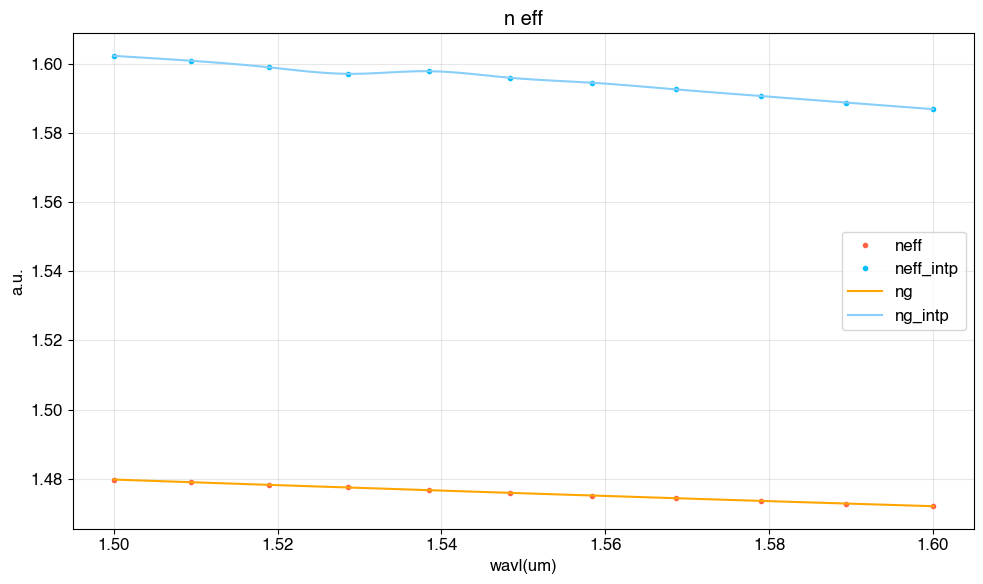

In [346]:
data_arr =  (   np.c_[wavl_arr, neff_arr[:,1], ng_arr[:,1]],
                np.c_[wavl_arr_intp, neff_intp, ng_intp],)

Plot_curve(data_arr,Y_legends=["neff","neff_intp","ng","ng_intp"],
                X_label="wavl(um)",Y_label="a.u.",
                xticks = [], xtickslabel=[],
                title="n eff",
                marker_list=[".",".","",""]*2,linestyle_list=["","","-","-"]*2,
                colors_list=['tomato','deepskyblue','orange','lightskyblue']*2,
                ylim = -1,dpi=400)

In [348]:
L1      = c/(ng_1550**2 * 20*10e9)
L2      = L1 * 1.005
D1      = c/(ng_1550**2 * L1) *2* np.pi
D2      = c/(ng_1550**2 * L2) *2* np.pi
D_ave   = c/(ng_1550**2 * (L1+L2)/2) *2 *np.pi
# D_ave = D1 * 0.99
epsilon = (L2-L1)/(L1+L2)
D_ave/(2*np.pi*10e9)



np.float64(19.950124688279303)

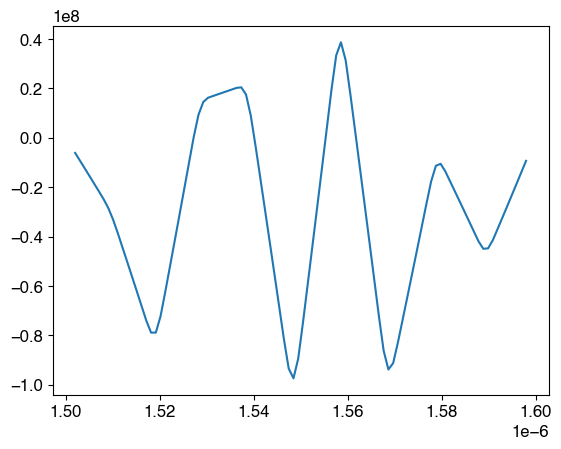

In [349]:
wavl_arr_intp_m =  wavl_arr_intp * 1e-6
Beta_1_intp = First_derivative_central_diff(neff_intp, wavl_arr_intp_m)
Beta_2_intp = wavl_arr_intp_m[2:-2]**3 / (2*np.pi*c**2) * First_derivative_central_diff(Beta_1_intp,
                                                                                wavl_arr_intp_m[1:-1])
D_2         = -c*D_ave**2 * Beta_2_intp / ng_intp[2:-2]
plt.plot(wavl_arr_intp_m[2:-2],D_2/(2*np.pi))

In [362]:
FSR = (D1-D2)/(2*epsilon)
M = 1/(2*epsilon)
D_ave/10e9
FSR/10e9/(2*np.pi)

np.float64(19.950248756219004)

In [367]:
def Mode_nonconserved_coupling(Max_M_idx,g,L,plot_coupled_curves=True,num_of_pts=100):
    m_arr = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts).reshape(-1,1)
    M0 = 0
    Y_legends = []
    Y_data = np.array(D1 * (m_arr - M0))
    Y_legends.append(r"Ring1 $\omega = \omega_0$+$(D_1-\bar{D})$(m-$M_0$)")
    for m in range(1,Max_M_idx):
        Y = D1 * (m_arr - M0) + m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append(r"Ring1 $\omega$ = $\omega_0$+$(D_1-\bar{D})$(m-$M_0$)$\pm$"+str(m)+"FSR")
        Y = D1 * (m_arr - M0) - m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append("")

    Y = D2 * (m_arr - M0)
    Y_data = np.c_[Y_data,Y]
    Y_legends.append(r"Ring2 $\omega = \omega_0$+$(D_2-\bar{D})$(m-$M_0$)")
    for m in range(1,Max_M_idx):
        Y = D2 * (m_arr - M0) +  m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append(r"Ring2 $\omega$ = $\omega_0$+$(D_2-\bar{D})$(m-$M_0$)$\pm$"+str(m)+"FSR")
        Y = D2 * (m_arr - M0) -  m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append("")
    Y_data = Y_data - D_ave * (m_arr - M0)

    if plot_coupled_curves:
        # D1m = 2*np.pi * FSR_func(m_arr,D_ave,g,L)
        # print(D1m)
        Y_p = Reson_freq(m_arr,D_ave,g,L)
        Y_m = -Reson_freq(m_arr,D_ave,g,L)
        Y_legends.append(r"supermode1 $\omega_{+}$")
        Y_legends.append(r"supermode1 $\omega_{-}$")
        Y_data = np.c_[Y_data,Y_p,Y_m]

    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
    xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"  for xtick in xticks]
    xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M
    # xtickslabels = np.c_[xtickslabels,""]

    data_arr = (np.c_[m_arr,Y_data/10e9/(2*np.pi)],)

    Plot_curve(data_arr,
                Y_legends=Y_legends,
                X_label='mode number m',Y_label=r"Frequency $\omega$/(2$\pi$) (GHz)",
                xticks=xticks, xtickslabel=xtickslabels,
                title = "Mode number non-conservation coupling",
                marker_list=[""]*12,
                linestyle_list=["-","dashed","dashed","dotted","dotted"]*2+["-","-"]*2,
                colors_list = ['tab:blue']*(Max_M_idx*2-1)+
                ['tab:red']*(Max_M_idx*2-1)+['tab:orange']*2+['tab:green']*2,
                ylim = 20, bbox_to_anchor=(1.05,0.8))

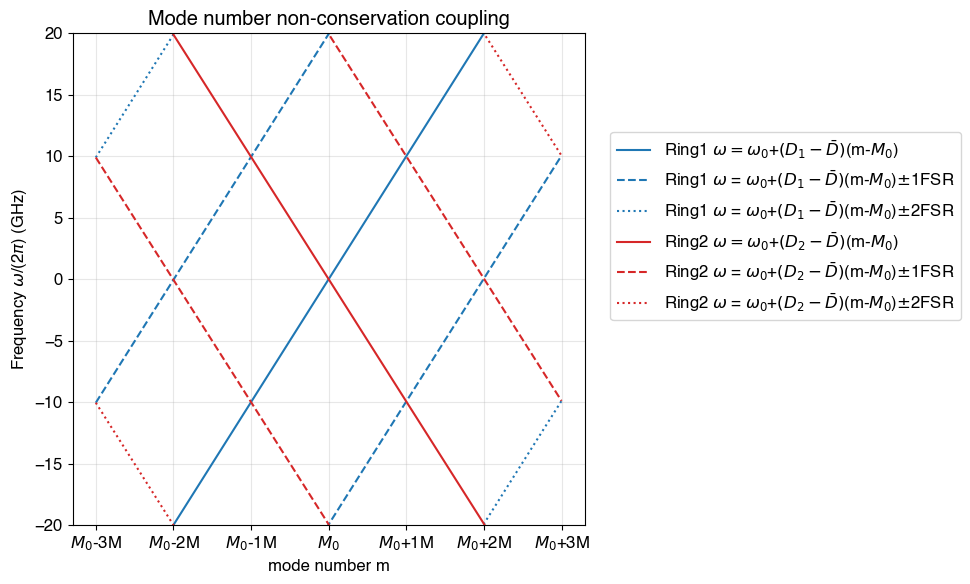

In [368]:
Mode_nonconserved_coupling(3,1,1,plot_coupled_curves=False)

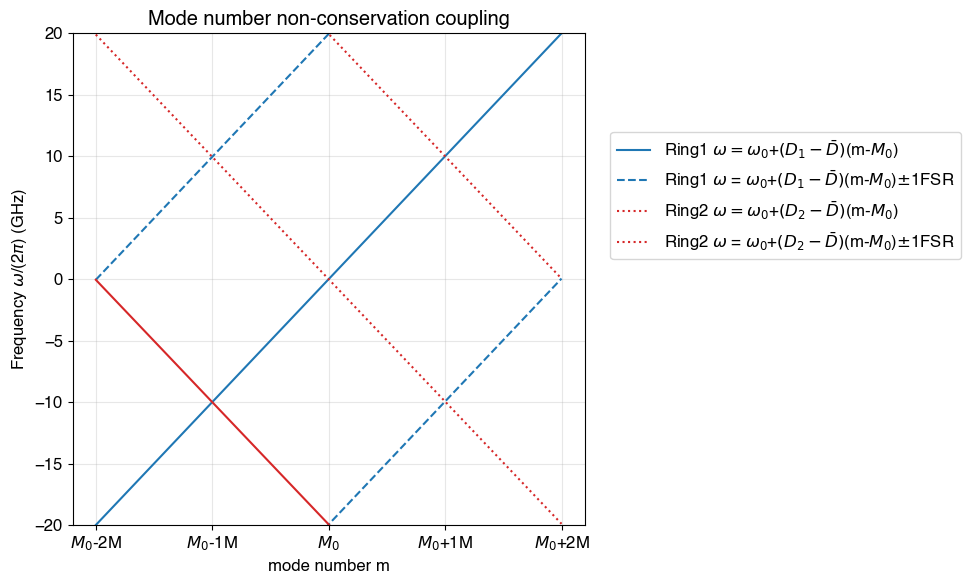

In [369]:
Mode_nonconserved_coupling(2,1,1,plot_coupled_curves=False)

In [370]:
# field_coefficients = [A,B]     E_supermode = A * E_1 + B * E_2
# E_1,E_2 are the eigenmodes of separate WGs. A,B are the coefficients
def Plot_field_profile(field,field_name,Plot_log = False,
                    save_name='./results/field_supermode_profile.png',dpi=600):
    fonttype = "Helvetica"
    fontsize = 4
    grid_linewidth = 1
    colormap = "jet"
    figsize =  (15,5)

    fig, ax = plt.subplots(1,3,figsize=figsize,dpi=dpi)
    plt.subplots_adjust(left=0.05, right=0.95, wspace =0.1, hspace =0.2)   #调整子图间距

    name_list = ['Abs','Re','Im']

    field_list = [np.abs(field),np.real(field),np.imag(field)]
    if Plot_log:
        field_list[0] = np.log(field_list[0])
    # Converting the unit of ticks to um
    yticks_prev = np.linspace(0,np.shape(field)[0],10)
    xticks_prev = np.linspace(0,np.shape(field)[1],10)
    xticks,yticks = self.Convert_ticks(xticks_prev,yticks_prev)

    for idx in range(3):
        # Plot the field profile
        im = ax[idx].imshow(field_list[idx], cmap=colormap)
        # Plot the boundaries of the WGs
        ax[idx].plot(WG1_x_arr,WG1_y_arr,color='black', linewidth=0.1)
        ax[idx].plot(WG2_x_arr,WG2_y_arr,color='black', linewidth=0.1)

        ax[idx].set_title(name_list[idx]+'('+field_name+')')
        cbar = fig.colorbar(im, ax=ax[idx], orientation='vertical',
                            label='', shrink=0.3, pad=0.02)
        ax[idx].set_xticks(xticks_prev)
        ax[idx].set_xticklabels(xticks)
        ax[idx].set_yticks(yticks_prev)
        ax[idx].set_yticklabels(yticks)
        ax[idx].set_xlabel("X(um)",fontsize=4)
        ax[idx].set_ylabel("Y(um)",fontsize=4)
        ax[idx].invert_yaxis()
        ax[idx].tick_params(axis='both',labelsize=5)

    plt.rcParams["font.family"] = fonttype
    plt.rcParams.update({'font.size': fontsize})
    plt.legend()

    plt.savefig(save_name,dpi=dpi)
    plt.close()
    # plt.show()
    return

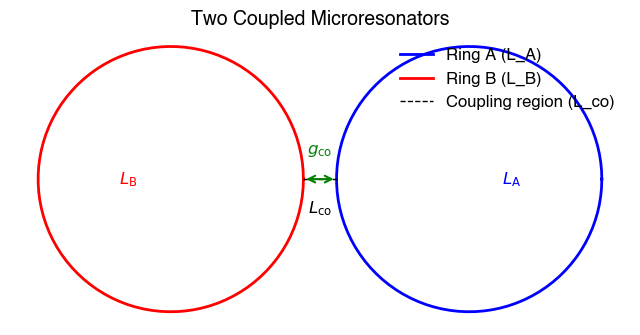

In [355]:
import matplotlib.pyplot as plt
import numpy as np

# 创建画布和坐标轴
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect('equal')
ax.axis('off')  # 隐藏坐标轴

# 定义微环参数
R1, R2 = 2.0, 2.0  # 两个环的半径
d = 0.5             # 耦合区域的间距
L_co = 1.0          # 耦合区域长度（近似）

# 绘制两个微环（跑道形结构）
theta = np.linspace(0, 2*np.pi, 100)

# 环A（右环）
x_A = R1 * np.cos(theta) + R1 + d/2
y_A = R1 * np.sin(theta)
ax.plot(x_A, y_A, color='blue', lw=2, label='Ring A (L_A)')

# 环B（左环）
x_B = R2 * np.cos(theta) - R2 - d/2
y_B = R2 * np.sin(theta)
ax.plot(x_B, y_B, color='red', lw=2, label='Ring B (L_B)')

# 绘制耦合区域（用虚线表示）
coupling_x = np.linspace(-d/2, d/2, 50)
coupling_y = np.zeros_like(coupling_x)
ax.plot(coupling_x, coupling_y, '--', color='black', lw=1, label='Coupling region (L_co)')

# 添加标注
ax.annotate('', xy=(d/2, 0), xytext=(-d/2, 0),
            arrowprops=dict(arrowstyle='<->', color='green', lw=1.5))
ax.text(0, 0.3, r'$g_{\mathrm{co}}$', ha='center', va='bottom', fontsize=12, color='green')
ax.text(R1 + d/2 + 0.5, 0, r'$L_{\mathrm{A}}$', ha='left', va='center', fontsize=12, color='blue')
ax.text(-R2 - d/2 - 0.5, 0, r'$L_{\mathrm{B}}$', ha='right', va='center', fontsize=12, color='red')
ax.text(0, -0.3, r'$L_{\mathrm{co}}$', ha='center', va='top', fontsize=12, color='black')

# 添加图例和标题
ax.legend(loc='upper right', frameon=False)
plt.title('Two Coupled Microresonators', fontsize=14)

# 显示图形
plt.show()

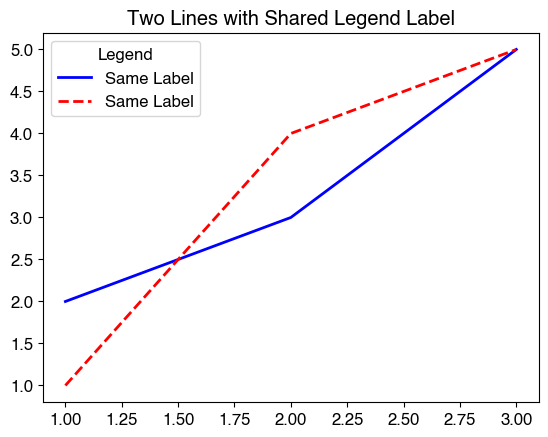

In [356]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 生成数据
x = [1, 2, 3]
y1 = [2, 3, 5]  # 第一条线（蓝色实线）
y2 = [1, 4, 5]  # 第二条线（红色虚线）

# 绘制线条，不设置标签
plt.plot(x, y1, color='blue', linestyle='-', linewidth=2)
plt.plot(x, y2, color='red', linestyle='--', linewidth=2)

# 创建代理对象（与线条样式一致）
legend_handles = [
    Line2D([], [], color='blue', linestyle='-', linewidth=2),  # 代理对象1
    Line2D([], [], color='red', linestyle='--', linewidth=2)   # 代理对象2
]

# 手动设置图例（共享同一标签）
plt.legend(
    handles=legend_handles,
    labels=['Same Label', 'Same Label'],  # 使用相同标签名称
    loc='upper left',
    title='Legend'
)

plt.title('Two Lines with Shared Legend Label')
plt.show()